# Player Similarity Search
- Will use PCA to identify the most similar players to a selected player. 
- Will be based on just PL players for the 23-24 season and their aggregated stats. 

## Packages 

In [1]:
# General 
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Data 
- Dataset involves cumulative player stats and their associated minutes for each position. 
- Will ignore goalkeepers and players who've played less than 90 mins. 

In [2]:
df = pd.read_csv('player_db.csv').iloc[:, 1:]
df = df[(df['Mins'] >= 90) & 
        (df['Position'] != 'Goalkeeper')].reset_index(drop=True)

df.head(5)

,playerName,PlayerID,Position,Mins,Passes Completed,Passes Attempted,Pass Completion Rate,Forward Passes,Long Passes,xT via Pass,...,Touches,Box Touches,Final 1/3 Touches,Progressive Passes,Progressive Carries,Box Passes,Box Carries,Successful Take Ons,xT Carry,xT Received
0,Aaron Cresswell,68049,Full Back,150,81.0,95.0,0.852632,39.0,4.0,0.666806,...,107.0,0.0,25.0,9.0,1.0,2.0,0.0,0.0,0.016506,0.060420
1,Aaron Hickey,402367,Full Back,761,243.0,277.0,0.877256,93.0,9.0,0.335290,...,385.0,7.0,79.0,8.0,9.0,3.0,3.0,5.0,0.115712,0.367486
2,Aaron Ramsey,423732,Attacking Mid/Winger,311,49.0,66.0,0.742424,11.0,1.0,0.028696,...,111.0,4.0,26.0,2.0,0.0,0.0,0.0,2.0,0.015490,0.239699
3,Aaron Ramsey,423732,Center Mid,201,54.0,67.0,0.805970,22.0,6.0,0.334595,...,107.0,5.0,36.0,5.0,1.0,2.0,1.0,1.0,0.051353,0.174548
4,Aaron Wan-Bissaka,331924,Full Back,950,427.0,515.0,0.829126,212.0,7.0,0.950796,...,667.0,12.0,140.0,20.0,8.0,7.0,3.0,10.0,0.264354,0.502824


- Will look at players most similar to Enzo Fernández
- Two options - can include all his minutes and compare to other Center Mids (but their mins won't be aggregated). Or just look at his Center Mid minutes. 
- Will opt for the former but the below facilitates for either. 

In [3]:
name = 'Enzo Fernández'
position = 'Center Mid'

In [4]:
def data_prep_posMins(df, position):
    
    df_pos = df[(df['Position'] == position)].reset_index(drop=True)

    col_90s = df_pos['Mins']/90
    for col in df_pos.iloc[:, 4:]:
        if col == 'Pass Completion Rate':
            continue 

        df_pos[col] = df_pos[col]/col_90s
        
    return df_pos


def data_prep_allMins(df, player, position):
    df1 = df[(df['Position'] == position) & 
             (df['playerName'] != player)].reset_index(drop=True)

    df2 = df[df['playerName'] == player].reset_index(drop=True)
    
    cols = ['Mins', 'Passes Completed', 'Passes Attempted', 'Forward Passes', 'Long Passes', 
            'xT via Pass', 'npxG', 'xA', 'Shots', 'Tackles', 'Interceptions', 'Fouls', 'Aerials', 'Recoveries', 
            'Ball Wins', 'Touches', 'Box Touches', 'Final 1/3 Touches', 'Progressive Passes', 
            'Progressive Carries', 'Box Passes', 'Box Carries', 'Successful Take Ons', 'xT Carry', 'xT Received']
    
    d1 = dict.fromkeys(cols, 'sum')
    df2 = df2.groupby(['playerName', 'PlayerID']) \
             .agg(d1) \
             .reset_index()

    df2['Pass Completion Rate'] = df2['Passes Completed'] / df2['Passes Attempted']
    df2['Position'] = position
    order = list(df2.columns[:2]) + [df2.columns[28]] + list(df2.columns[2:6]) + [df2.columns[27]] + list(df2.columns[6:27])

    df2 = df2[order]
    
    df_pos = pd.concat([df1, df2], axis=0).reset_index(drop=True)
    
    col_90s = df_pos['Mins']/90
    for col in df_pos.iloc[:, 4:]:
        if col == 'Pass Completion Rate':
            continue 

        df_pos[col] = df_pos[col]/col_90s

        
    return df_pos

In [5]:
# Will inc Enzo's CM mins
data_prep_posMins(df, position)

# Will include all of Enzo's mins
df = data_prep_allMins(df, name, position)
df.head(5)

,playerName,PlayerID,Position,Mins,Passes Completed,Passes Attempted,Pass Completion Rate,Forward Passes,Long Passes,xT via Pass,...,Touches,Box Touches,Final 1/3 Touches,Progressive Passes,Progressive Carries,Box Passes,Box Carries,Successful Take Ons,xT Carry,xT Received
0,Aaron Ramsey,423732,Center Mid,201,24.179104,30.000000,0.805970,9.850746,2.686567,0.149818,...,47.910448,2.238806,16.119403,2.238806,0.447761,0.895522,0.447761,0.447761,0.022994,0.078156
1,Abdoulaye Doucouré,116317,Center Mid,437,20.183066,24.919908,0.809917,9.267735,0.411899,0.037483,...,37.688787,3.295195,15.858124,1.029748,0.617849,0.617849,0.617849,1.029748,0.045769,0.174352
2,Adam Wharton,430774,Center Mid,414,24.565217,32.391304,0.758389,12.173913,1.739130,0.124915,...,44.130435,0.652174,13.478261,3.695652,0.434783,1.956522,0.000000,0.000000,0.008305,0.028158
3,Albert Sambi Lokonga,349102,Center Mid,939,41.884984,47.635783,0.879276,22.907348,2.971246,0.093490,...,60.766773,0.575080,11.789137,2.875399,0.766773,0.383387,0.095847,0.766773,0.031598,0.044821
4,Alex Iwobi,136824,Center Mid,320,37.125000,43.593750,0.851613,22.218750,1.968750,0.077358,...,56.531250,1.125000,20.531250,2.812500,1.125000,0.281250,0.562500,1.687500,0.065068,0.075532


In [6]:
# Need to standardise the data for PCA/Clustering - first split by cols that don't need standardising 
df_info, df_metrics = df.iloc[:, :4], df.iloc[:, 4:]
cols = df_metrics.columns.tolist()

# Standardise
vals = df_metrics.values
scaler = preprocessing.MinMaxScaler()
vals_scaled = scaler.fit_transform(vals)
vals_norm = pd.DataFrame(vals_scaled, columns=cols)
vals_norm.head(5)

,Passes Completed,Passes Attempted,Pass Completion Rate,Forward Passes,Long Passes,xT via Pass,npxG,xA,Shots,Tackles,...,Touches,Box Touches,Final 1/3 Touches,Progressive Passes,Progressive Carries,Box Passes,Box Carries,Successful Take Ons,xT Carry,xT Received
0,0.119069,0.113141,0.554056,0.107467,0.406292,0.270103,0.289590,0.188527,0.280597,0.649876,...,0.148337,0.146144,0.198631,0.179104,0.051962,0.092869,0.077944,0.131841,0.097690,0.069003
1,0.067748,0.049409,0.567564,0.097884,0.062292,0.039678,0.281211,0.090395,0.215103,0.380435,...,0.016130,0.215103,0.194584,0.082380,0.071701,0.064073,0.107551,0.303204,0.206504,0.180789
2,0.124028,0.143142,0.391226,0.145654,0.263010,0.219020,0.039759,0.288635,0.090821,0.401570,...,0.099446,0.042572,0.157722,0.295652,0.050456,0.202899,0.000000,0.000000,0.027508,0.010903
3,0.346465,0.334393,0.804919,0.322086,0.449344,0.154560,0.069511,0.193424,0.140149,0.240282,...,0.314621,0.037540,0.131559,0.230032,0.088984,0.039759,0.016684,0.225772,0.138800,0.030267
4,0.285332,0.283683,0.710253,0.310767,0.297736,0.121472,0.186492,0.141259,0.470000,0.185547,...,0.259839,0.073438,0.266966,0.225000,0.130556,0.029167,0.097917,0.496875,0.298710,0.065954


## Model 
- As mentioned, will use PCA
- To identify the most similar players to Enzo in the PL during the 23-24 seasons (so far). 

In [7]:
pca = PCA()
pca.fit(vals_norm)

PCA()

Text(0, 0.5, 'variance %')

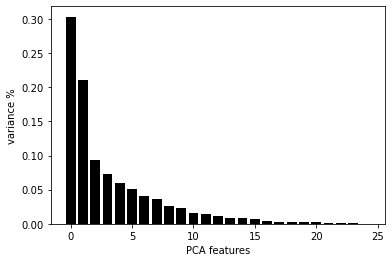

In [8]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

- Can see the first two PCA features explain > 50% of the variance. 

In [9]:
pca_2d = PCA(n_components = 2)
df_reduced = pd.DataFrame(pca_2d.fit_transform(vals_norm))

In [10]:
df_reduced = pd.DataFrame(pca_2d.fit_transform(vals_norm), columns=['x', 'y'])
df_reduced.head(5)

,x,y
0,-0.280661,0.144791
1,-0.493944,0.281377
2,-0.357081,-0.028577
3,0.001598,-0.250669
4,0.057507,0.116038


In [11]:
df = pd.concat([df_info, df_reduced], axis=1)

In [12]:
x,y = df[df['playerName'] == name]['x'].tolist()[0], df[df['playerName'] == name]['y'].tolist()[0]

df['Difference Score'] = round(np.sqrt((x - df['x'])**2 + (y - df['y'])**2), 3)
df = df.sort_values(by='Difference Score').reset_index(drop=True)[['playerName', 'Mins', 'Difference Score']]
df.columns = ['Player', 'Minutes', 'Difference Score']
df.head(11)

,Player,Minutes,Difference Score
0,Enzo Fernández,1919,0.000
1,Tom Cairney,1217,0.095
2,Mateo Kovacic,868,0.150
3,Joe Gomez,204,0.189
4,Bruno Guimarães,2469,0.210
5,James Milner,326,0.221
6,Douglas Luiz,2427,0.223
7,Declan Rice,2571,0.226
8,Conor Gallagher,1413,0.269
9,Giovani Lo Celso,327,0.316
